<h1><center>Color Processing </center></h1>

In this notebook, we present how to denoise and inpaint our first **multichannel** data using CIL, i.e., a data with only 3 channels that contains information from the **Red**, **Green** and **Blue** bands.

We will consider the cases of 

* denoising a noisy image corrupted by Gaussian noise,
* inpainting + denoising a noisy image corrupted by Salt \& Pepper noise with missing text information.

<h1><center>Total variation Denoising </center></h1>

We recall that the definition of the Total Variation, used for gray-valued images, is

$$
\mathrm{TV}(u) = \|Du\|_{2,1} = \sum_{i,j}^{M,N}\big(|(D_{y}u, D_{x}u)|_{2}\big)_{i,j} =  \sum_{i,j}^{M,N} \big(\sqrt{ (D_{y}u_{k})^{2} + (D_{x}u_{k})^{2}}\big)_{i,j}.
$$

This can be extended for vector-valued images which results to a **vectorial** formulation of the total variation. The gradient for the **RGB** case is now $Du=(Du_{1}, Du_{2}, Du_{3})$, where for each $k=1,2,3$, $Du_{k}:=(D_{y}u_{k}, D_{x}u_{k})$. 

For this type of multichannel data, we can create different configurations on how the **color channels**, the **derivatives** and the **image pixels** are correlated and under which norm. One generic approach for this regulariser is presented in [Duran et al](https://arxiv.org/pdf/1508.01308.pdf#page=8), where the **Collaborative Total variation** is introduced, i.e.,

$$
\|A\|_{p,q,r} := \bigg(\sum_{i=1}^{N}\quad\bigg(\sum_{j=1}^{M}\quad\bigg(\sum_{k=1}^{C} |A_{i,j,k}|^{p}\bigg)^{\frac{q}{p}}\quad\bigg)^{\frac{r}{q}}\quad\bigg)^{\frac{1}{r}}\quad .
$$

For simplicity, in this notebook, we will use a _Channelwise TV_ definition, namely, 

$$
\begin{equation}
\mathrm{VTV}(u)  := \|D u\|_{2,1}  = \sum_{k=1}^{3}\sum_{i,j=1}^{M,N} (|Du_{k}|_{2})_{i,j} = 
                 \sum_{k=1}^{3}\sum_{i,j=1}^{M,N} \big( \sqrt{ (D_{y}u_{k})^{2} + (D_{x}u_{k})^{2}}\big) = \sum_{k=1}^{3} \mathrm{TV}(u_{k}).
\label{tv_color}
\end{equation}
$$

The above definition corresponds to the $\ell_{2,1,1}$ (derivative, pixels, color) Collaborative TV. This means that, an $\ell_{2}$ norm is applied for the derivatives, followed by an $\ell_{1}$ norm for the pixels of the image and a final $\ell_{1}$ norm for the three channels.

For data $b$ corrupted with Gaussian noise, the minimisation problem is:

$$
\begin{equation}
u^{*} = \underset{u}{\operatorname{argmin}}  \frac{1}{2}\| b - u \|^{2}_{2} + \alpha\,\mathrm{VTV}(u)
\label{ROF}
\end{equation}.
$$

In [1]:
# Import libraries
from cil.optimisation.functions import TotalVariation
from cil.utilities import dataexample, noise

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

## Load data and corrupt with gaussian noise

In [2]:
# Load Rainbow data
data = dataexample.RAINBOW.get(size=(500,500), scale=(0,1))
data.reorder(['horizontal_y', 'horizontal_x','channel'])

noisy_data = noise.gaussian(data, seed = 10, var = 0.005)

We solve tha above minimisation problem using the `proximal` method of the `TotalVariation` class.

In [3]:
alpha = 0.05
TV = alpha * TotalVariation(max_iteration=500)
proxTV = TV.proximal(noisy_data, tau=1.0)

/home/vaggelis/miniconda3/envs/cil_fully3d/lib/python3.7/site-packages/cil/optimisation/operators/GradientOperator.py:84: UserWarning: Warning: correlation='Space' on multi-channel dataset will use `numpy` backend
  warnings.warn("Warning: correlation='Space' on multi-channel dataset will use `numpy` backend")


Initialised GradientOperator with numpy backend


/home/vaggelis/miniconda3/envs/cil_fully3d/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
/home/vaggelis/miniconda3/envs/cil_fully3d/lib/python3.7/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


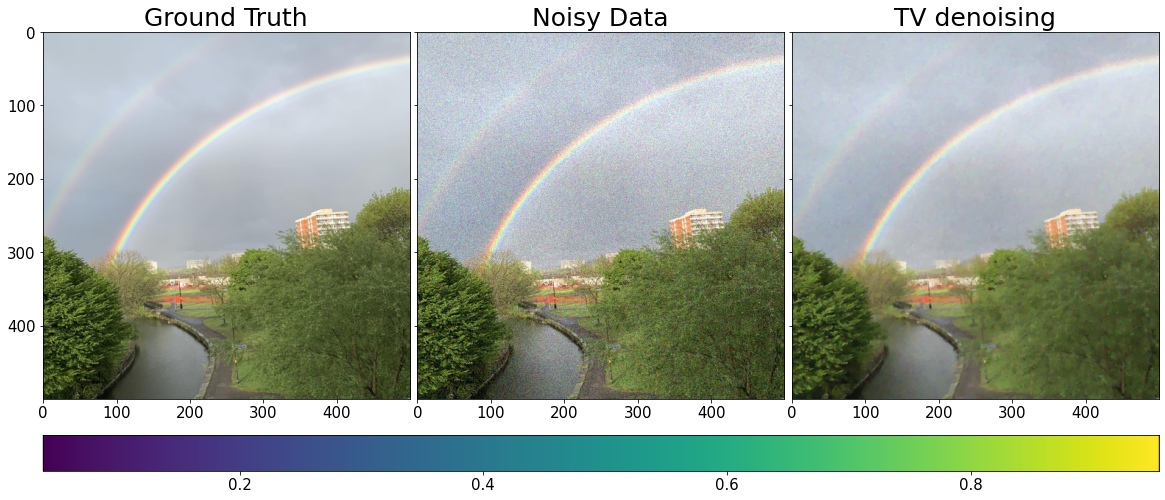

In [4]:
images = [data.as_array(), noisy_data.as_array(), proxTV.as_array()],  
                             
labels_x = ["Ground Truth", "Noisy Data", "TV denoising"]

# set fontszie xticks/yticks
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = plt.figure(figsize=(20, 20))

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.1,
                cbar_mode='single',
                cbar_location='bottom',
                cbar_size = 0.5,
                cbar_pad=0.4
                )

k = 0
for ax in grid:
    
    
    img = ax.imshow(images[0][k])
    ax.set_title(labels_x[k],fontsize=25)
    k+=1
    
cbar = ax.cax.colorbar(img)
plt.show()

<h1><center>Total Generalised Variation Inpainting </center></h1>

Given an image where a specific region is unknown, the task of image inpainting is to recover the missing region $\mathcal{D}$ from the known part of the image $\Omega$. For this experiment, we replace the Total variation term, with a higher-order regulariser, namely the **Total Generalised Variation (TGV)** introduced in [Bredies et al](https://epubs.siam.org/doi/abs/10.1137/090769521?mobileUi=0). This regulariser is able to obtain piecewise smooth solutions and restore staircasing artifacts that TV promotes.

We let $\alpha, \beta>0$ be regularisation parameters and define

$$
\begin{equation}
\mathrm{TGV}_{\alpha, \beta}(u) = \min_{w} \alpha \|D u - w \|_{2,1} + \beta\|\mathcal{E}w\|_{2,1},
\label{TGV}
\end{equation}$$

where $\mathcal{E}$ denotes the **Symmetrised Gradient** operator defined as 

$$
\mathcal{E}w = \frac{1}{2}(D w + D w^{T}).
$$

The minimisation problem under the TGV regulariser and the $L^{1}$ norm as a data fidelity term, which is suitable for  is the following:

<a id='TGV_L1'></a>
$$
\begin{equation}
\begin{aligned}
u^{*} =\underset{u}{\operatorname{argmin}} & \|\mathcal{M}u-b\|_{1} + \mathrm{TGV}_{\alpha, \beta}(u) \Leftrightarrow \\
(u^{*},w^{*}) =\underset{u, w}{\operatorname{argmin}} &  \|\mathcal{M}u -b\|_{1} + \alpha \|D u - w \|_{2,1} + \beta\|\mathcal{E}w\|_{2,1},
\end{aligned}
\label{TGV_L1_inpainting}
\end{equation}
$$

where the $\mathcal{M}$ is a diagonal operator with 1 in the diagonal elements corresponding to pixels in $\Omega\setminus\mathcal{D}$ and 0 in $\mathcal{D}$.


In [5]:
# Import libraries
from cil.framework import ImageGeometry
from cil.optimisation.operators import MaskOperator, BlockOperator, SymmetrisedGradientOperator, \
                                GradientOperator, ZeroOperator, IdentityOperator, ChannelwiseOperator

from cil.optimisation.functions import ZeroFunction, L1Norm, MixedL21Norm, BlockFunction
from cil.optimisation.algorithms import PDHG

import numpy as np

from PIL import Image, ImageFont, ImageDraw

## Create corrupted image

In [6]:
im = data.array
ig = data.geometry

# Add text to the image
tmp = Image.fromarray(np.uint8(im*255)).convert('RGB')
text = "\n This is a double rainbow.  Remove the text using the Core Imaging Library.\n"*15
draw = ImageDraw.Draw(tmp)
font = ImageFont.truetype('FreeSerifBold.ttf', 13)
draw.text((0, 0), text, (0, 0, 0), font=font)

# Create a ImageData
im1 = np.array(tmp)
im1 = im1/im1.max()
ig1 = ig.copy()
data1 = ig1.allocate()
data1.fill(im1)

## Create mask from corrupted image and apply MaskOperator channelwise

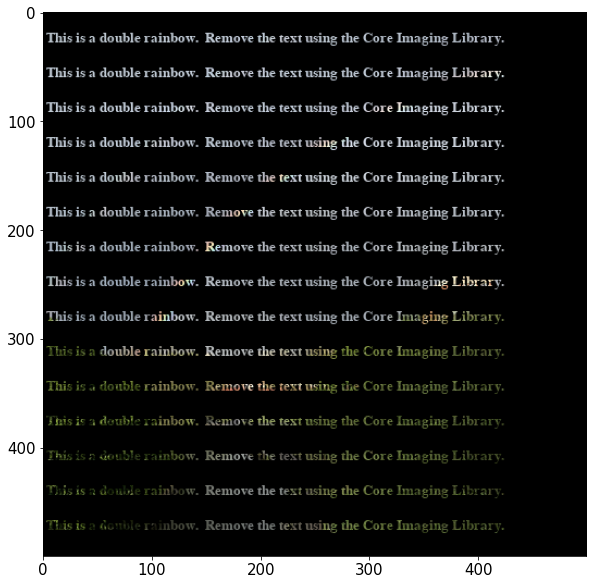

In [7]:
# Mask that contains only text information
tmp_mask_array = np.abs(im1 - im)
plt.figure(figsize=(10,10))
plt.imshow(tmp_mask_array)
plt.show()

tmp = (data1-data).abs()==0
mask2D = tmp[:,:,0]

# Apply MaskOperator for all the 3 channels: red, green, blue
mask = ig.subset(channel=0).allocate(True,dtype=np.bool)
mask.fill(mask2D)
MO = ChannelwiseOperator(MaskOperator(mask), 3, dimension = 'append')

## Add salt and pepper noise

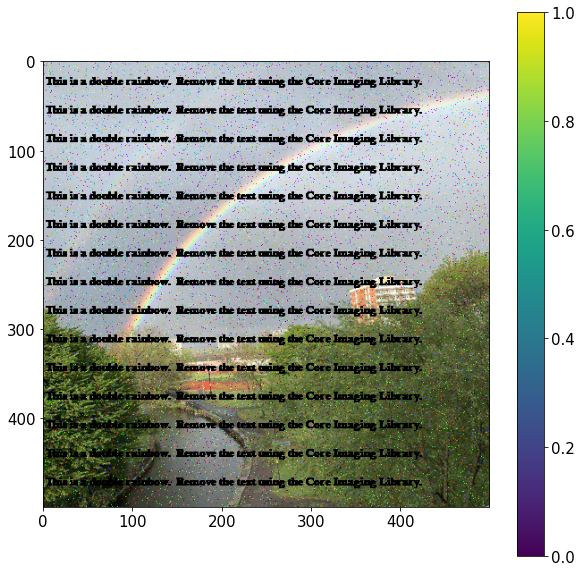

In [8]:
noisy_data = noise.saltnpepper(data1, amount=0.03, seed = 10)
noisy_data = MO.direct(noisy_data) 

plt.figure(figsize=(10,10))
plt.imshow(noisy_data.as_array())
plt.colorbar()
plt.show()

## Setup PDHG for TGV regularisation

We solve the above problem using the `PDGH` algorithm. Recall, that we need to define the triplet ($K$,  $\mathcal{F}$, $\mathcal{G}$) and write the above problem into the following form:

$$
\begin{equation}
u^{*} =\underset{u}{\operatorname{argmin}} \mathcal{F}(Ku) + \mathcal{G}(u).
\label{general_form}
\end{equation}
$$

Let $\textbf{u} = (u, w)\in \mathbb{X}$ and define an operator $K:\mathbb{X}\rightarrow\mathbb{Y}$ as

$$
\begin{equation}
K = 
\begin{bmatrix}
\mathcal{M} & \mathcal{O}\\
D & -\mathcal{I}\\
\mathcal{O} & \mathcal{E}
\end{bmatrix} \quad\Rightarrow\quad
K\textbf{u} = 
K \begin{bmatrix}
u\\
w
\end{bmatrix}=
\begin{bmatrix}
\mathcal{M}u\\
Du - w\\
\mathcal{E}w
\end{bmatrix} = 
\begin{bmatrix}
y_{1}\\
y_{2}\\
y_{3}
\end{bmatrix} = \textbf{y}\in \mathbb{Y},
\label{def_K}
\end{equation}
$$

where $\mathcal{O}$, $\mathcal{I}$ denote the zero and identity operators respectively.

For the function $\mathcal{F}$, we have that

$$
\begin{equation}
\begin{aligned}
& \mathcal{F}(\textbf{y})  := \mathcal{F}(y_{1}, y_{2}, y_{3}) = f_{1}(y_{1}) +  f_{2}(y_{2})  +  f_{3}(y_{3}), \mbox{ where},\\
& f_{1}(y_{1}) :=  \| y_{1} - b\|_1,\, f_{2}(y_{2}) :=  \alpha \|y_{2}\|_{2,1},\, f_{3}(y_{3}) := \beta\|y_{3}\|_{2,1},
\end{aligned}
\label{def_f}
\end{equation} 
$$

and for the function $\mathcal{G}$, $\mathcal{G}(\textbf{u}) = \mathcal{G}(u,w) = O(u)\equiv 0 $ is the zero function. 

We conclude that

$$
\begin{equation*}
\begin{aligned}
f(K\textbf{u}) + g(\textbf{u}) & = f\bigg(\begin{bmatrix}
\mathcal{M}u\\
Du - w\\
\mathcal{E}w
\end{bmatrix}\bigg)  = f_{1}(\mathcal{M}u) + f_{2}(Du-w) + f_{3}(\mathcal{E}w) \\
& = \|\mathcal{M}u -b\|_{1} + \alpha \|D u - w \|_{2,1} + \beta\|\mathcal{E}w\|_{2,1},
\end{aligned}
\end{equation*}
$$

which is exactly the objective function in [TGV_L1](#TGV_L1). 


In [9]:
# Regularisation parameters
alpha = 0.6
beta = 0.2

# Define BlockFunction f
f2 = alpha * MixedL21Norm()
f3 = beta * MixedL21Norm() 
f1 = L1Norm(b=noisy_data)
F = BlockFunction(f1, f2, f3)         

# Define function g 
G = ZeroFunction()

# Define BlockOperator K
K11 = MO
K21 = GradientOperator(ig)
K32 = SymmetrisedGradientOperator(K21.range)
K12 = ZeroOperator(K32.domain, ig)
K22 = IdentityOperator(K21.range)
K31 = ZeroOperator(ig, K32.range)
K = BlockOperator(K11, K12, K21, -K22, K31, K32, shape=(3,2) )

normK = K.norm()
eta = 5
sigma = (1./normK)*eta
tau = (1./normK)/eta

# Setup and run the PDHG algorithm
pdhg = PDHG(f=F,g=G,operator=K,
            max_iteration = 500, sigma=sigma, tau=tau,
            update_objective_interval = 100)
pdhg.run(500,verbose = 1)

Initialised GradientOperator with numpy backend
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          3.79444e+05


/home/vaggelis/miniconda3/envs/cil_fully3d/lib/python3.7/site-packages/cil/framework/framework.py:2185: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


      100        500         0.288          2.21243e+04
      200        500         0.290          1.76469e+04
      300        500         0.291          1.72389e+04
      400        500         0.292          1.71169e+04
      500        500         0.291          1.70440e+04
-------------------------------------------------------
      500        500         0.291          1.70440e+04
Stop criterion has been reached.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/vaggelis/miniconda3/envs/cil_fully3d/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.


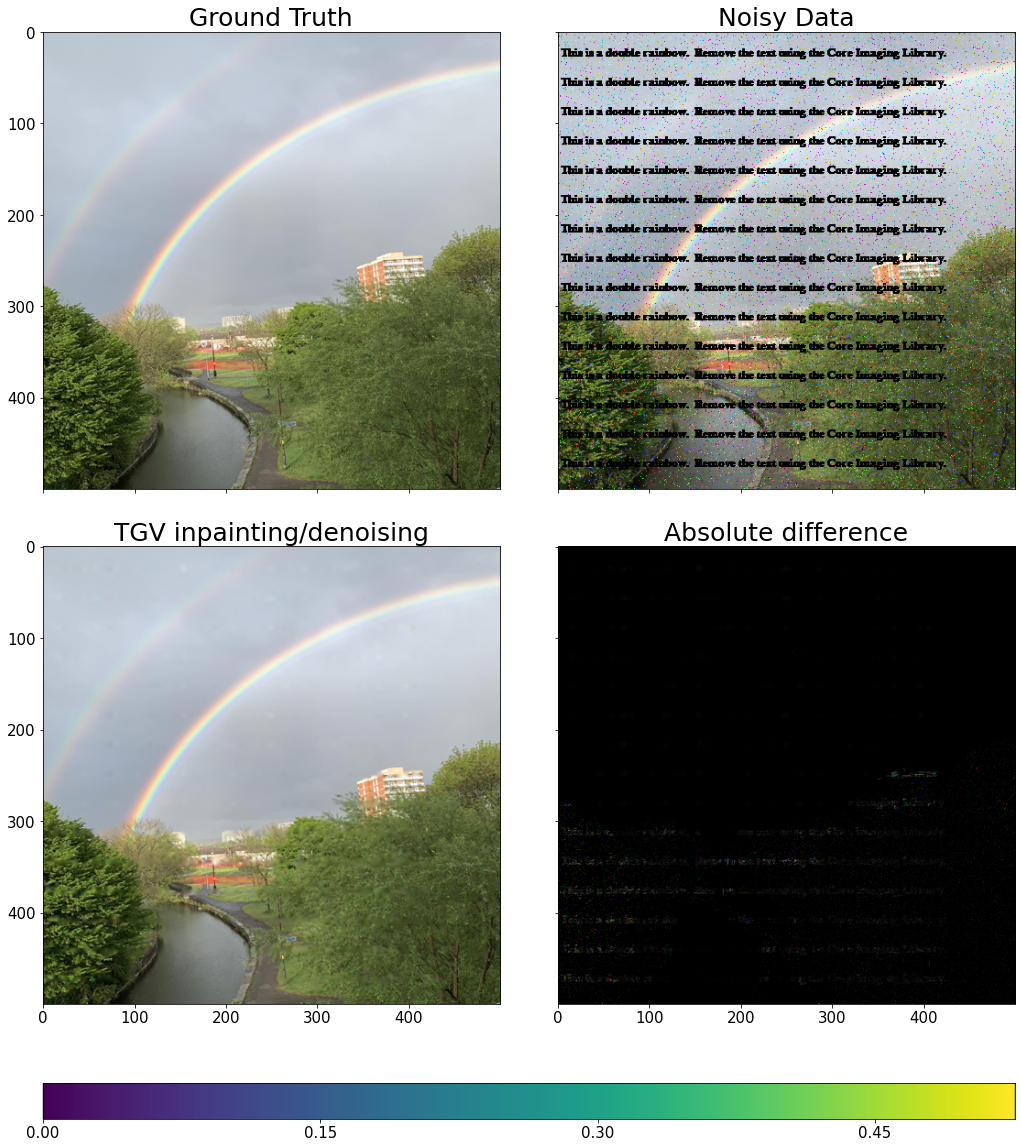

In [10]:
images = [data, noisy_data, \
          pdhg.solution[0], (pdhg.solution[0]-data).abs()],  
                             
labels_x = ["Ground Truth", "Noisy Data", "TGV inpainting/denoising", "Absolute difference"]

# set fontszie xticks/yticks
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = plt.figure(figsize=(20, 20))

grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 2),
                axes_pad=0.8,
                cbar_mode='single',
                cbar_location='bottom',
                cbar_size = 0.5,
                cbar_pad=0.3
                )

k = 0
for ax in grid:
        
    img = ax.imshow(images[0][k].as_array())
    ax.set_title(labels_x[k],fontsize=25)
    k+=1
    
cbar = ax.cax.colorbar(img)
plt.show()

<h1><center>Conclusions</center></h1>

In this notebook, we presented how to reconstruct multichannel data with 3 channels, using two different regularisers and data fitting terms. The following notebooks will demonstrate how to reconstruct multichannel data for tomography applications:

* **Dynamic CT**: Channels contain temporal information from the acquisition data.
* **Hypespectral CT**: Channels contain spectral energy information acquired from an energy-sensitive X-ray detector.
* **Sequence MRI**: Channels contain information from two MR images with different contrast.
